In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F

import torch
import os

import numpy as np


from torch.utils.data import DataLoader
from tqdm import tqdm

import cv2

import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from prettytable import PrettyTable
from CLIP_utils import get_features, get_lr

import optuna

In [2]:
prettyTable = PrettyTable(['Noise factor', 'Accuracy', 'ROC AUC'])

In [3]:
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize
from classes.dataset.HatefulMemesDataset import HatefulMemesDataset

In [4]:
data_dir = r'E:\datasets\MADE\3_graduation\parthplc\archive\data\\'

In [5]:
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

#### Предобработка изображений

In [8]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [9]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler, noise_factor):    
    best_model_name = None
    loss_history = []
    train_history = []
    val_history = []
    top_val_accuracy = 0.3
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device)#x.type(torch.float).cpu()
            y = y.to(device)#y.type(torch.float).cpu()
            #model = model.cpu()
            prediction = model(x)    
            loss_value = loss(prediction, y.type(torch.long))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        #print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))

  
        if val_accuracy > top_val_accuracy:
            #
            top_val_accuracy = val_accuracy
            m_name = f'{noise_factor}_classifier_{epoch}_{round(val_accuracy, 3)}.ckpt'
            best_model_name = m_name
            torch.save(model, open(m_name, 'wb'))
            #print("saved", m_name)

    return loss_history, train_history, val_history, best_model_name
        
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0 
    for i_step, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.to(device)
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
         
    return val_accuracy


In [10]:
results = {}

In [11]:
model_names = clip.available_models()

In [12]:
CROP_SIZE=224

transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])    

train_dataset = HatefulMemesDataset(train_path, transforms)
val_dataset = HatefulMemesDataset(dev_path, transforms)

model, preprocess = clip.load('ViT-L/14', device=device)

features_train, labels_train = get_features(model, train_dataset)
features_val, labels_val = get_features(model, val_dataset)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:09<00:00,  1.86s/it]


In [13]:
def add_noise(inputs, noise_factor):
    noisy = inputs + torch.rand_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [14]:
class FeaturesDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, noise_factor):
        self.features = features
        self.labels = labels
        self.noise_factor = noise_factor
        
    def __getitem__(self, index: int):
        features = add_noise(self.features[index], self.noise_factor)
        return features, self.labels[index]
    
    def __len__(self):
        return len(self.features)

In [15]:
def compare(noise_factor):
    print('noise_factor', noise_factor)
    features_train_dataset = FeaturesDataset(features_train, labels_train, noise_factor)
    features_val_dataset = FeaturesDataset(features_val, labels_val, noise_factor)

    input_shape = features_train[0].shape[0]
    num_classes = 2


    torch.manual_seed(1024)

    shape = 256
    nn_model = nn.Sequential(
                nn.Linear(input_shape, shape),
                nn.Dropout(0.66),
                nn.BatchNorm1d(shape),
                nn.ReLU(inplace=True),    

                nn.Linear(shape, shape),
                nn.Dropout(0.66),
                nn.BatchNorm1d(shape),
                nn.ReLU(inplace=True),    

                nn.Linear(shape, num_classes),
                )

    nn_model = nn_model.to(device)
    #print(nn_model)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

    loss_history, train_history, val_history, best_model_name = train_model(
        nn_model, 
        DataLoader(features_train_dataset, batch_size=500),
        DataLoader(features_val_dataset, batch_size=500),
        loss, optimizer, 100, scheduler, f'noise_factor_{noise_factor}_')


    print('noise_factor', noise_factor)    
    fig = plt.figure(figsize=(10, 8))    
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, label='loss')
    plt.plot(train_history, label='train accuracy')
    plt.plot(val_history, label='val accuracy')
    fig.legend()
    plt.show()

    print("best model:", best_model_name)
    best_model = torch.load(open(best_model_name, 'rb'))
    #print(best_model)

    best_model = best_model.to(device)
    
    best_model.eval()
    for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
        x = x.to(device)
        prediction = best_model(x)

    acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction.cpu(), 1)[1])
    auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction.cpu()[:,1].detach().numpy())
    prettyTable.add_row([noise_factor, acc_score, auc_score])
    print(noise_factor, CROP_SIZE, input_shape, acc_score, auc_score)

    
    print('noise_factor', noise_factor)  
    fpr, tpr, thresh = roc_curve(labels_val, prediction.cpu()[:,1].detach().numpy(), pos_label=1)

    random_probs = [0 for i in range(len(labels_val))]
    p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
    auc_score = roc_auc_score(labels_val, prediction.cpu()[:,1].detach().numpy())
    print(auc_score)

    plt.plot(fpr, tpr, linestyle='--',color='orange')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.title('ROC Curve', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive rate',fontsize=18)

    plt.show();

    return (acc_score, auc_score)

noise_factor 0.0
noise_factor 0.0


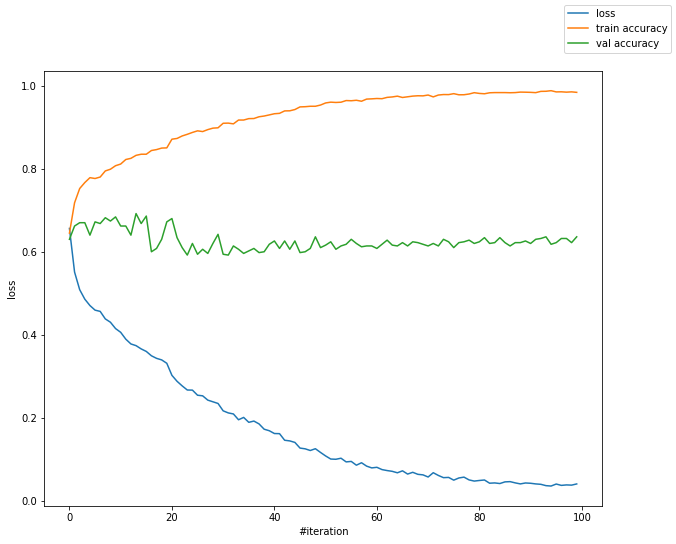

best model: noise_factor_0.0__classifier_13_0.692.ckpt
0.0 224 1536 0.692 0.7352000000000001
noise_factor 0.0
0.7352000000000001


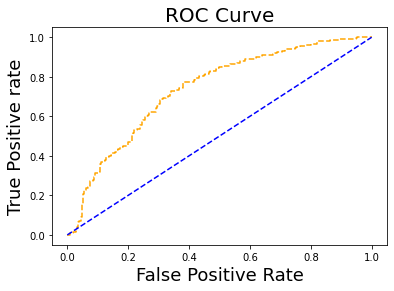

noise_factor 0.1
noise_factor 0.1


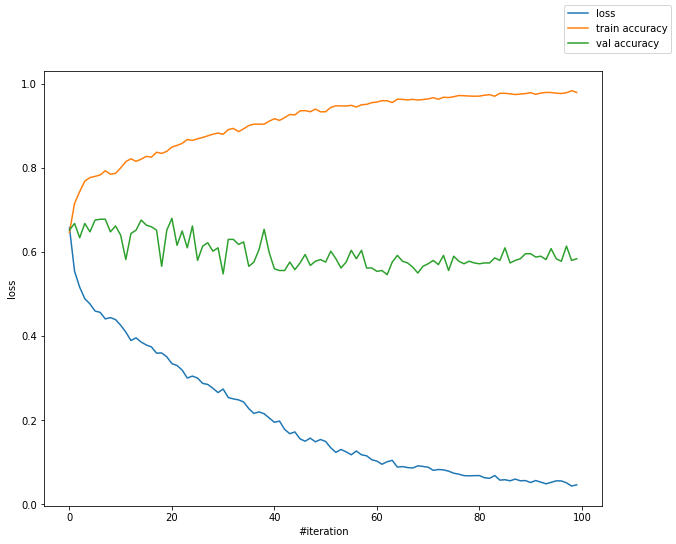

best model: noise_factor_0.1__classifier_20_0.68.ckpt
0.1 224 1536 0.682 0.7326560000000001
noise_factor 0.1
0.7326560000000001


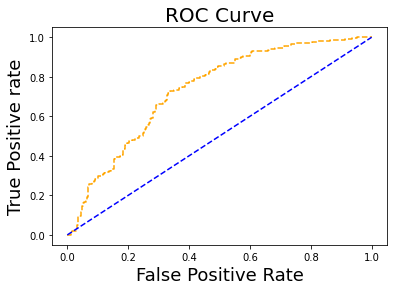

noise_factor 0.2
noise_factor 0.2


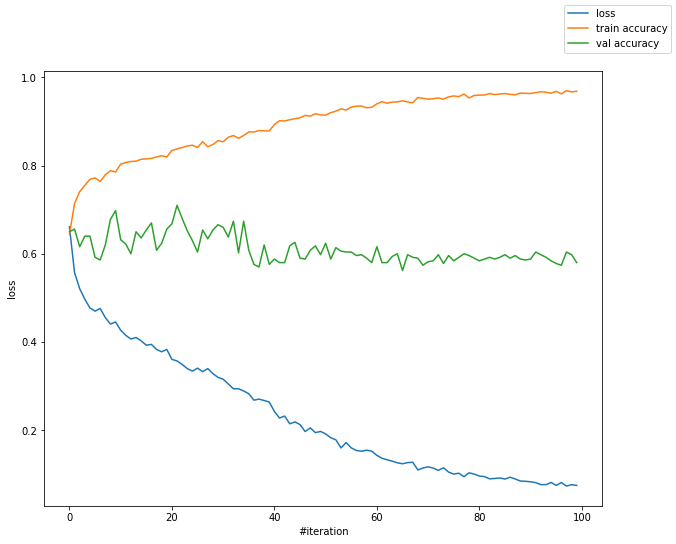

best model: noise_factor_0.2__classifier_21_0.71.ckpt
0.2 224 1536 0.702 0.74856
noise_factor 0.2
0.74856


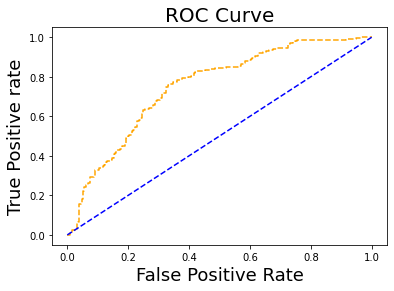

noise_factor 0.3
noise_factor 0.3


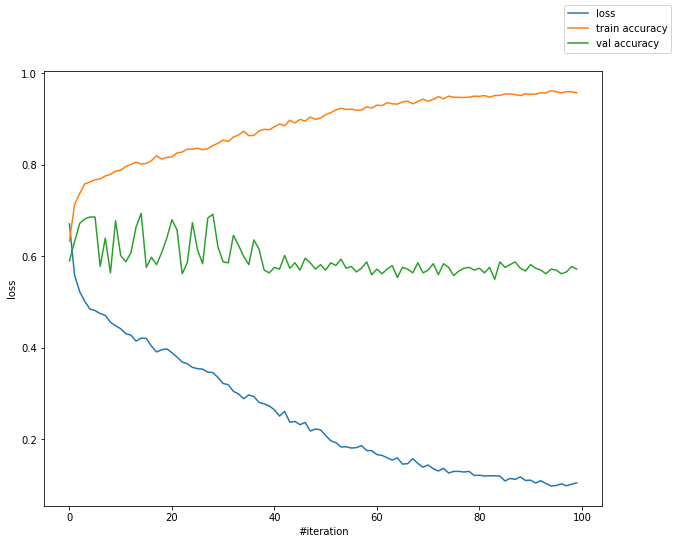

best model: noise_factor_0.3__classifier_14_0.694.ckpt
0.3 224 1536 0.7 0.7522079999999999
noise_factor 0.3
0.7522079999999999


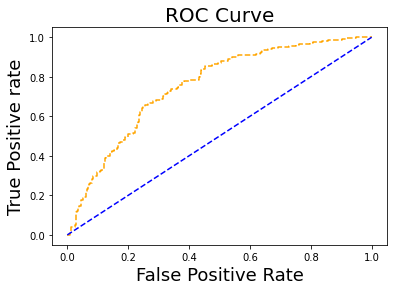

noise_factor 0.4
noise_factor 0.4


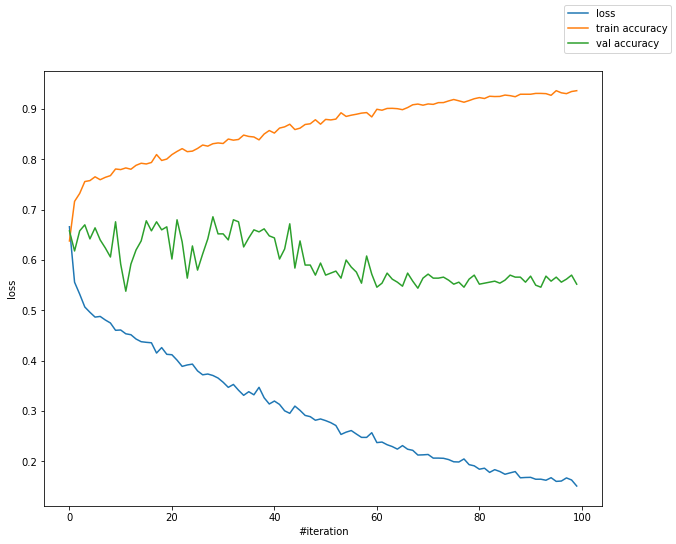

best model: noise_factor_0.4__classifier_28_0.686.ckpt
0.4 224 1536 0.696 0.7629039999999999
noise_factor 0.4
0.7629039999999999


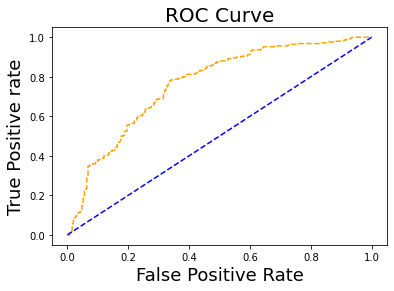

noise_factor 0.5
noise_factor 0.5


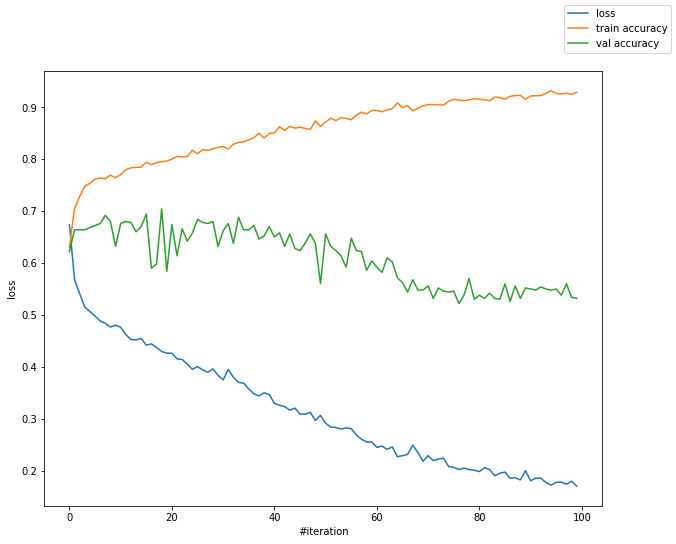

best model: noise_factor_0.5__classifier_18_0.704.ckpt
0.5 224 1536 0.696 0.7592639999999999
noise_factor 0.5
0.7592639999999999


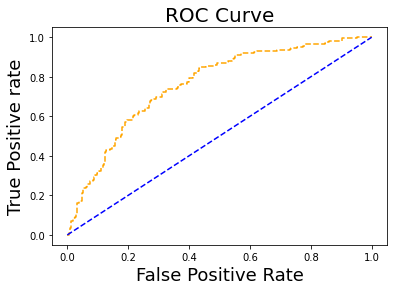

noise_factor 0.6
noise_factor 0.6


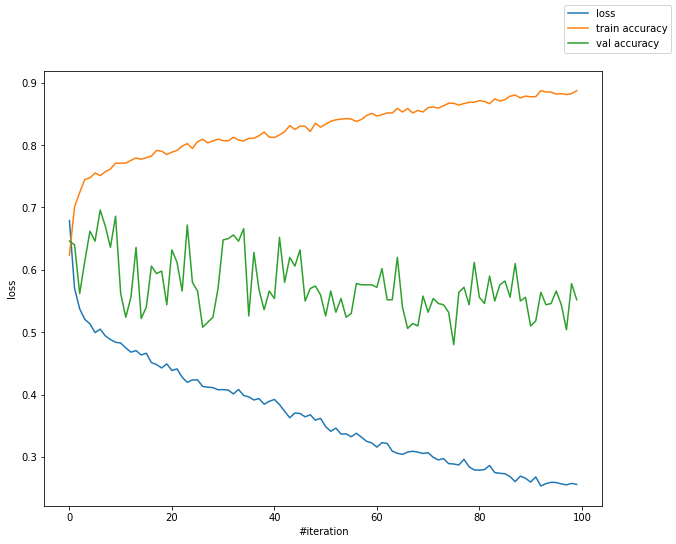

best model: noise_factor_0.6__classifier_6_0.696.ckpt
0.6 224 1536 0.704 0.7571519999999999
noise_factor 0.6
0.7571519999999999


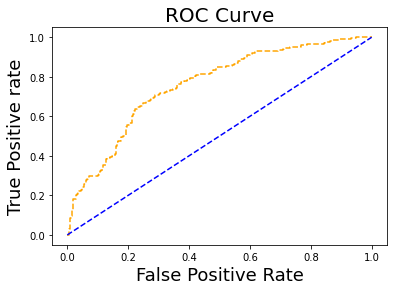

noise_factor 0.7
noise_factor 0.7


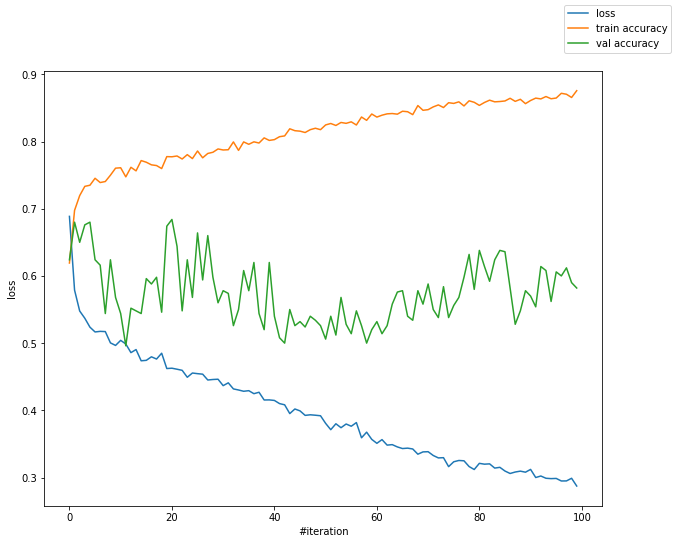

best model: noise_factor_0.7__classifier_20_0.684.ckpt
0.7 224 1536 0.686 0.7525599999999999
noise_factor 0.7
0.7525599999999999


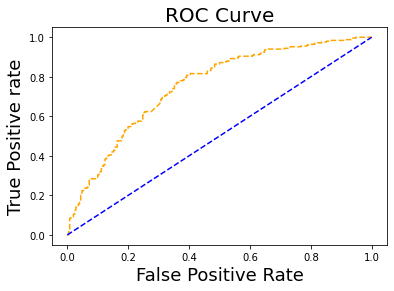

noise_factor 0.8
noise_factor 0.8


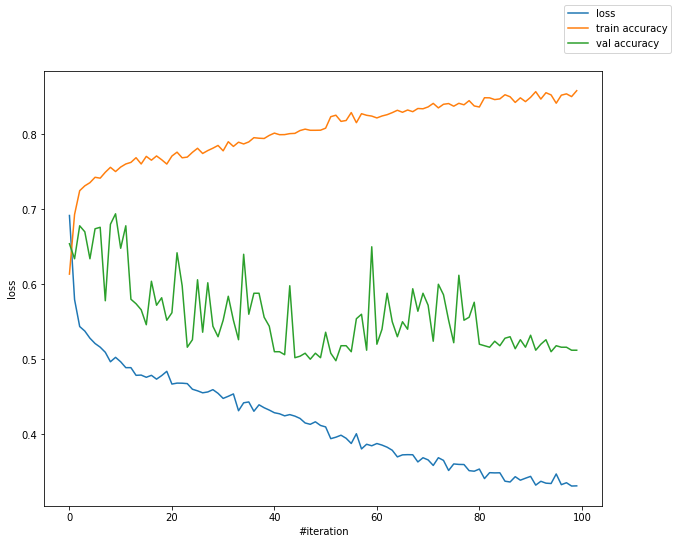

best model: noise_factor_0.8__classifier_9_0.694.ckpt
0.8 224 1536 0.682 0.7487360000000001
noise_factor 0.8
0.7487360000000001


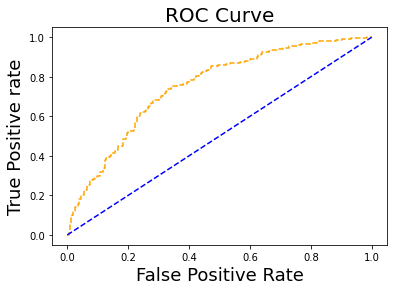

noise_factor 0.9
noise_factor 0.9


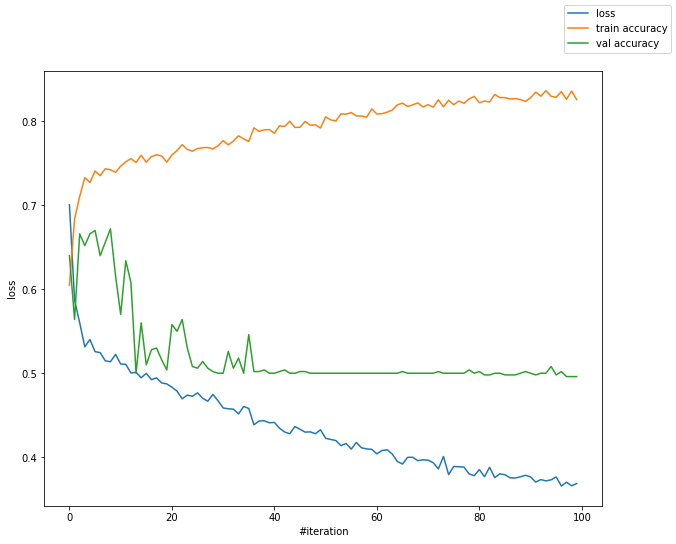

best model: noise_factor_0.9__classifier_8_0.672.ckpt
0.9 224 1536 0.668 0.7412639999999999
noise_factor 0.9
0.7412639999999999


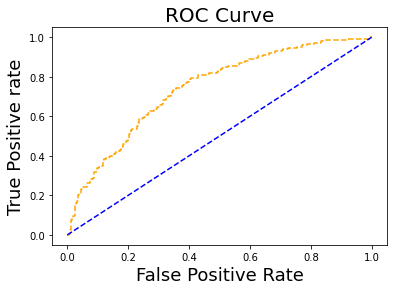

In [16]:
for x in range(10):
    results[x] = compare(x / 10)

In [17]:
print(prettyTable)

+--------------+----------+--------------------+
| Noise factor | Accuracy |      ROC AUC       |
+--------------+----------+--------------------+
|     0.0      |  0.692   | 0.7352000000000001 |
|     0.1      |  0.682   | 0.7326560000000001 |
|     0.2      |  0.702   |      0.74856       |
|     0.3      |   0.7    | 0.7522079999999999 |
|     0.4      |  0.696   | 0.7629039999999999 |
|     0.5      |  0.696   | 0.7592639999999999 |
|     0.6      |  0.704   | 0.7571519999999999 |
|     0.7      |  0.686   | 0.7525599999999999 |
|     0.8      |  0.682   | 0.7487360000000001 |
|     0.9      |  0.668   | 0.7412639999999999 |
+--------------+----------+--------------------+


In [18]:
results

{0: (0.692, 0.7352000000000001),
 1: (0.682, 0.7326560000000001),
 2: (0.702, 0.74856),
 3: (0.7, 0.7522079999999999),
 4: (0.696, 0.7629039999999999),
 5: (0.696, 0.7592639999999999),
 6: (0.704, 0.7571519999999999),
 7: (0.686, 0.7525599999999999),
 8: (0.682, 0.7487360000000001),
 9: (0.668, 0.7412639999999999)}